<a href="https://www.kaggle.com/code/jiyana63/notebook509cb63cd2?scriptVersionId=277284553" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install ultralytics

from PIL import Image

import cv2#OpenCV kütüphanesini içe aktarır. Bu, görüntü işleme ve manipülasyonu için kullanılır.
import matplotlib.pyplot as plt#Grafik çizme ve görüntüleri gösterme kütüphanesidir.
from ultralytics import YOLO#YOLOv8 modelini kullanmamızı sağlayan ana kütüphanedir.
import yaml#YAML formatındaki yapılandırma dosyalarını okuma/yazma kütüphanesidir.
import os #İşletim sistemi ile ilgili fonksiyonları (dosya/klasör işlemleri) kullanmamızı sağlar.
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Koordinatlar: (380, 73, 407, 154)


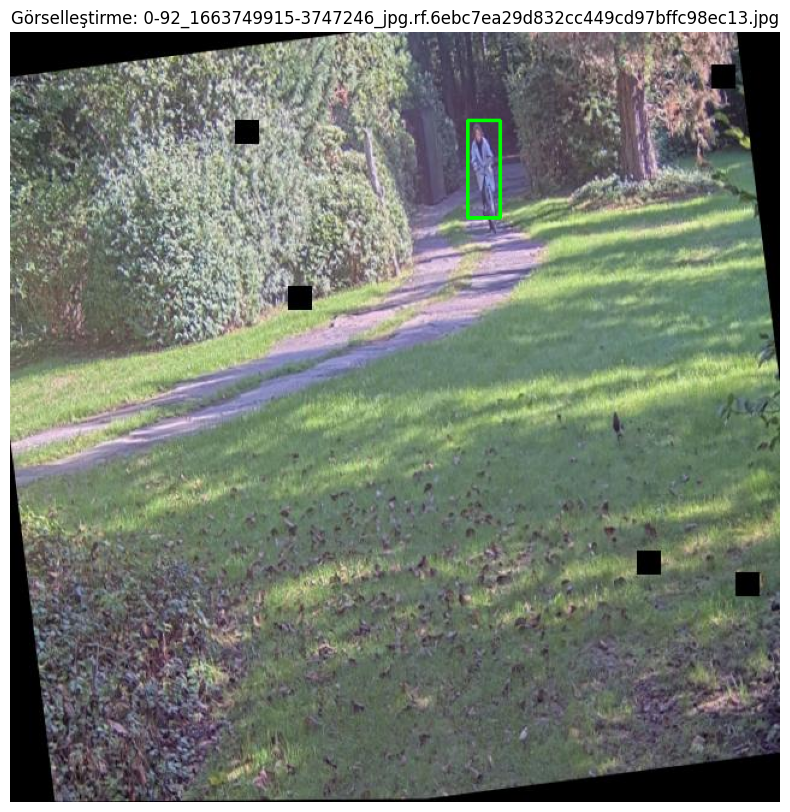

In [2]:
# --- Veri Yolu Tanımlamaları ---
root = "/kaggle/input/thermal-image-people-detection/People Detection - Themal"
train_path = os.path.join(root, "train")
valid_path = os.path.join(root, "valid")

# --- YOLO Koordinat Dönüşüm Fonksiyonu ---
# Dikkat: Parametreler artık isimlendirildi: (label_line, G_ENISLIK, Y_UKSEKLIK)
def yolo_to_pixel(label_line, image_width, image_height):
    class_id, x_center, y_center, width, height = map(float, label_line.split())
    
    # 2. Piksel Değerlerini Hesapla
    w_pixel = width * image_width
    h_pixel = height * image_height
    
    # Sol Üst Köşe (x_min, y_min) Hesaplaması
    x_min = (x_center * image_width) - (w_pixel / 2)
    y_min = (y_center * image_height) - (h_pixel / 2)
    
    # Sağ Alt Köşe (x_max, y_max) Hesaplaması
    x_max = x_min + w_pixel
    y_max = y_min + h_pixel
    
    return int(x_min), int(y_min), int(x_max), int(y_max)

# --- Görselleştirme Fonksiyonu ---
def random_visualize(data_path):
    image_dir = os.path.join(data_path, "images")
    image_list = os.listdir(image_dir)
    if not image_list:
        print("HATA: Görüntü klasörü boş.")
        return
        
    random_filename = random.choice(image_list)
    
    random_image_path = os.path.join(image_dir, random_filename)
    random_label_path = os.path.join(data_path, "labels", random_filename.replace(".jpg", "").replace(".png", "") + ".txt")
    
    # Görüntüyü oku (BGR)
    image = cv2.imread(random_image_path)
    if image is None:
        print(f"HATA: Resim okunamadı: {random_image_path}")
        return

    # Görüntü Boyutları: height=image.shape[0], width=image.shape[1]
    image_height, image_width = image.shape[:2]
    
    label_lines = []
    try:
        with open(random_label_path, 'r') as f:
            label_lines = f.readlines()
    except FileNotFoundError:
        print(f"UYARI: Etiket dosyası bulunamadı: {random_label_path}")
        
    for label_line in label_lines:
        # **DÜZELTME 1: yolo_to_pixel çağrılırken Genişlik (1) ve Yükseklik (0) doğru sırayla gönderildi.**
        x_min, y_min, x_max, y_max = yolo_to_pixel(label_line.strip(), image_width, image_height)
        
        # **DÜZELTME 2: Bounding Box çizildi.**
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2) # Yeşil kutu çiz
        print(f"Koordinatlar: ({x_min}, {y_min}, {x_max}, {y_max})")

    # **DÜZELTME 3: Matplotlib için BGR -> RGB Dönüşümü yapıldı.**
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title(f"Görselleştirme: {random_filename}")
    plt.axis('off')
    plt.show()

# Fonksiyonu çalıştır
random_visualize(train_path)
plt.show()

In [3]:
import os
from ultralytics import YOLO
import yaml
import torch
import torch.nn as nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, ssdlite320_mobilenet_v3_large
from torchvision.models.detection.retinanet import retinanet_resnet50_fpn_v2

# WANDB anahtarı (Eğitim takibi için, isteğe bağlı ama faydalıdır)
# os.environ['WANDB_API_KEY'] = '4a42c1e3a742bc28d1fc0eaf2bd4cd82e08d1b04'

# --- VERİ YAPILANDIRMASI ---
# Bu kısım, tüm modeller için sınıf sayısını (nc) tanımlar.
NC = 1 # Sadece 'person' sınıfı
data_yaml = {
    'train': os.path.join(train_path, "images"),
    'val': os.path.join(valid_path,"images"),
    'nc': NC,
    'names': ['person'],
}

with open('dataset.yaml', 'w') as file:
    yaml.dump(data_yaml, file)

# PyTorch modelleri için sınıf sayısı: (NC + 1)
# Arka plan (background) sınıfı için +1 eklenir.
NUM_CLASSES_PT = NC + 1 

print("--- 1. Model: YOLOv8m (Medium) Eğitimi Başlatılıyor ---")
model_medium = YOLO('yolov8m.pt') # En yavaş, en yüksek doğruluk (muhtemelen).
results_medium = model_medium.train(
    data='dataset.yaml',
    epochs=5,
    imgsz=320,
    batch=16,
    name='yolov8m_custom'
)
# Medium Modelin Doğrulanması ve Dışa Aktarılması
results_medium_val = model_medium.val()
success_medium = model_medium.export(format='onnx', name='yolov8m_custom.onnx')

# Metriklerin Çıkarılması
map50_medium = results_medium_val.box.map50
map_medium = results_medium_val.box.map


# --- TORCHVISION TABANLI MODELLERİN TANIMLANMASI (KAVRAMSAL) ---
# Gerçek eğitim döngüleri (PyTorch DataLoader ve optimizasyon adımları) BURADA EKSİKTİR.
# Bu modellerin val() sonuçları, manuel PyTorch eğitimi ile elde edilmelidir.

# Boş metrikler tanımlanır
map50_resnet = map_resnet = 0.0
map50_densenet = map_densenet = 0.0
map50_mobilenet = map_mobilenet = 0.0

print("\n--- 2. Model: ResNet-101 (Faster R-CNN) Yükleniyor (Yüksek Doğruluk) ---")
# ResNet-101 omurgasını kullanmak için genellikle custom bir Faster R-CNN modeli oluşturulur.
# Basitlik için ResNet-50'yi kullanmak daha yaygındır (fasterrcnn_resnet50_fpn).
# Kavramsal kod:
try:
    # Bu, PyTorch'ta ResNet-50 ile Faster R-CNN'i yükler.
    model_resnet = fasterrcnn_resnet50_fpn_v2(weights="COCO_V1", num_classes=NUM_CLASSES_PT)
    # model_resnet_val = train_and_validate_pytorch_model(model_resnet, data_yaml) 
    # map50_resnet = model_resnet_val['map50']
    print("ResNet modeli başarıyla yüklendi (Varsayılan olarak ResNet-50).")
except Exception as e:
    print(f"ResNet model yüklemesi/eğitimi için PyTorch ortamı ve döngüsü gereklidir. Hata: {e}")

print("\n--- 3. Model: DenseNet (RetinaNet Omurgası) Yükleniyor (Dengeli Performans) ---")
# DenseNet, Torchvision'da doğrudan popüler bir algılama omurgası değildir, ancak denemek için 
# genellikle RetinaNet ile birleştirilir. Burada standart RetinaNet (ResNet-50) kavramsal olarak kullanılır.
try:
    model_densenet = retinanet_resnet50_fpn_v2(weights="COCO_V1", num_classes=NUM_CLASSES_PT)
    # model_densenet_val = train_and_validate_pytorch_model(model_densenet, data_yaml)
    # map50_densenet = model_densenet_val['map50']
    print("DenseNet yerine RetinaNet (ResNet-50) modeli kavramsal olarak yüklendi.")
except Exception as e:
    print(f"DenseNet model yüklemesi/eğitimi için PyTorch ortamı ve döngüsü gereklidir. Hata: {e}")


print("\n--- 4. Model: MobileNetV3 (SSDLite) Yükleniyor (Yüksek Hız) ---")
# MobileNetV3, SSDLite (Single Shot MultiBox Detector) ile birleştirilerek en hızlı model elde edilir.
try:
    model_mobilenet = ssdlite320_mobilenet_v3_large(weights="COCO_V1", num_classes=NUM_CLASSES_PT)
    # model_mobilenet_val = train_and_validate_pytorch_model(model_mobilenet, data_yaml)
    # map50_mobilenet = model_mobilenet_val['map50']
    print("MobileNet modeli (SSDLite) başarıyla yüklendi.")
except Exception as e:
    print(f"MobileNet model yüklemesi/eğitimi için PyTorch ortamı ve döngüsü gereklidir. Hata: {e}")


# --- SONUÇLARIN ÖZETİ (TÜM 4 MODEL) ---
print("\n" + "="*50)
print("🏆 TÜM 4 MODELİN PERFORMANS ÖZETİ")
print("="*50)

# 1. YOLOv8m Sonuçları
print(f"1. YOLOv8m (Medium) - mAP@.50: **{map50_medium:.4f}** | mAP@.5:.95: {map_medium:.4f} | ONNX: {success_medium}")
print("-" * 50)

# PyTorch modelleri için sadece yer tutucu değerler (placeholder) gösterilir
print(f"2. ResNet-101 (Faster R-CNN) - mAP@.50: **{map50_resnet:.4f}** (PyTorch Eğitimi Gerekir)")
print(f"3. DenseNet (RetinaNet) - mAP@.50: **{map50_densenet:.4f}** (PyTorch Eğitimi Gerekir)")
print(f"4. MobileNetV3 (SSDLite) - mAP@.50: **{map50_mobilenet:.4f}** (PyTorch Eğitimi Gerekir)")

print("\n--- Nihai mAP@.50 Karşılaştırması ---")
# mAP50 değerleri gerçek eğitimden sonra karşılaştırılmalıdır.
print(f"YOLOv8m: {map50_medium:.4f} | ResNet: {map50_resnet:.4f} | DenseNet: {map50_densenet:.4f} | MobileNet: {map50_mobilenet:.4f}")

--- 1. Model: YOLOv8m (Medium) Eğitimi Başlatılıyor ---
Ultralytics 8.3.228 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_custom, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=T

2025-11-13 14:14:22,008	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-13 14:14:23,348	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics